<a href="https://colab.research.google.com/github/garylau1/model_training/blob/main/animal_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
import tarfile

# Mount Google Drive
drive.mount('/content/drive')

# Define file paths (update these paths as needed)
drive_path = "/content/drive/My Drive/"  # Change if files are in a subfolder
images_tar_path = os.path.join(drive_path, "images.tar.gz")
annotations_tar_path = os.path.join(drive_path, "annotations.tar.gz")

# Define extraction paths
extract_path = "/content/dataset"

# Ensure extraction directory exists
os.makedirs(extract_path, exist_ok=True)

# Function to extract tar files
def extract_tar(file_path, destination):
    with tarfile.open(file_path, "r") as tar:
        tar.extractall(path=destination)
    print(f"Extracted: {file_path} -> {destination}")

# Extract files
extract_tar(images_tar_path, extract_path)
extract_tar(annotations_tar_path, extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracted: /content/drive/My Drive/images.tar.gz -> /content/dataset
Extracted: /content/drive/My Drive/annotations.tar.gz -> /content/dataset


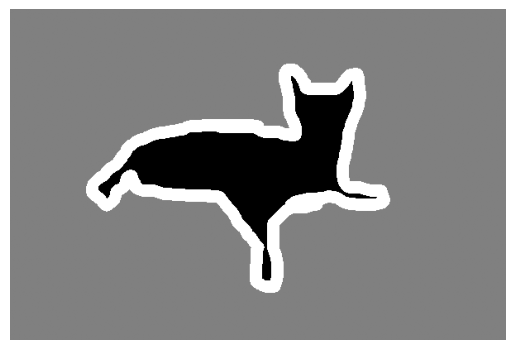

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Define the image path
image_path = "/content/dataset/annotations/trimaps/Abyssinian_1.png"


# Open the image
image = Image.open(image_path)

# Display the image
plt.imshow(image,cmap='gray')
plt.axis("off")  # Hide axes
plt.show()

In [ ]:
import numpy as np
image_array = (np.array(image)-1)/255
image_array

array([[0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157],
       ...,
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157]])

In [ ]:
image_dir = '/content/dataset/images'
trimap_dir = '/content/dataset/annotations/trimaps'

# List all files in each directory
image_files = os.listdir(image_dir)
trimap_files = os.listdir(trimap_dir)

# If you want to filter out only files (in case there are directories), you can use:
image_files = [image_dir+"/"+ f for f in image_files if os.path.isfile(os.path.join(image_dir, f)) and f.endswith(".jpg") ]
trimap_files = [trimap_dir+"/"+f for f in trimap_files if os.path.isfile(os.path.join(trimap_dir, f)) and not f.startswith(".")]
image_files.sort()
trimap_files.sort()
len(image_files),len(trimap_files),image_files[0:10],trimap_files[0:10]


(7390,
 7390,
 ['/content/dataset/images/Abyssinian_1.jpg',
  '/content/dataset/images/Abyssinian_10.jpg',
  '/content/dataset/images/Abyssinian_100.jpg',
  '/content/dataset/images/Abyssinian_101.jpg',
  '/content/dataset/images/Abyssinian_102.jpg',
  '/content/dataset/images/Abyssinian_103.jpg',
  '/content/dataset/images/Abyssinian_104.jpg',
  '/content/dataset/images/Abyssinian_105.jpg',
  '/content/dataset/images/Abyssinian_106.jpg',
  '/content/dataset/images/Abyssinian_107.jpg'],
 ['/content/dataset/annotations/trimaps/Abyssinian_1.png',
  '/content/dataset/annotations/trimaps/Abyssinian_10.png',
  '/content/dataset/annotations/trimaps/Abyssinian_100.png',
  '/content/dataset/annotations/trimaps/Abyssinian_101.png',
  '/content/dataset/annotations/trimaps/Abyssinian_102.png',
  '/content/dataset/annotations/trimaps/Abyssinian_103.png',
  '/content/dataset/annotations/trimaps/Abyssinian_104.png',
  '/content/dataset/annotations/trimaps/Abyssinian_105.png',
  '/content/dataset/ann

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)
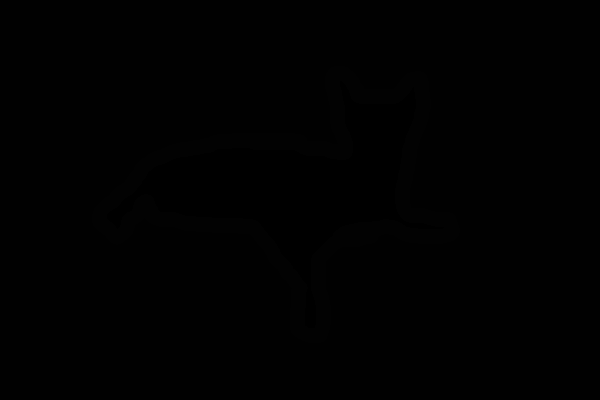

In [ ]:
np.array(Image.open(trimap_files[0]))-1

The error you're encountering seems to be due to the fact that the input image is in CV_64F format, which is a 64-bit floating point, but the cv2.cvtColor() function expects an 8-bit image (uint8) or a 16-bit image (uint16)


In [ ]:

import os
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CustomDataset(Dataset):
    def __init__(self, image_dir, trimap_dir):
        self.image_dir = image_dir
        self.trimap_dir = trimap_dir
        self.image_names = [f for f in image_files if os.path.isfile(os.path.join(image_dir, f)) and f.endswith(".jpg") ]

        self.trimap_names = [f for f in trimap_files if os.path.isfile(os.path.join(trimap_dir, f)) and not f.startswith(".")]
        self.image_names.sort()
        self.trimap_names.sort()



    def __len__(self):
        return len(self.image_names)
    def mask(self,image):
        image_array = (np.array(image)-1)
        return image_array

    def get_transform(self,all=True):
      if all:
        transform = A.Compose([
        A.Resize(128, 128),  # Resize images and masks to 128x128

        A.HorizontalFlip(p=0.5),
        #ToTensorV2() # Convert images and masks to torch tensors
        ])  # This makes sure the mask is handled separately as a mask
      else:
        transform = A.Compose([
        #A.Resize(128, 128),
        #A.HorizontalFlip(p=0.5),  # Random horizontal flip
        A.RandomBrightnessContrast(p=0.2),  # Random brightness and contrast
        A.CLAHE(p=0.3),
        A.AdditiveNoise(
        noise_type="uniform",  # Use uniform noise distribution
        spatial_mode="constant",  # Apply constant noise across channels
        noise_params={"ranges": [(-0.05, 0.05)]},  # Small range for noise
        p=0.2  # Apply with probability of 0.2
        ),
        ToTensorV2()
          # Convert images and masks to torch tensors
        ])

      return transform

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        trimap_names = self.trimap_names[idx]
        image_path = os.path.join(self.image_dir, image_name)
        trimap_path = os.path.join(self.trimap_dir, trimap_names)  # Assuming trimap files have the same name as images
        #
        image = np.array(Image.open(image_path).convert("RGB").resize((128, 128)))
        #image = np.resize(image, (128, 128, 3))
        trimap = Image.open(trimap_path).convert("L").resize((128, 128))  # Convert trimap to grayscale
        trimap = self.mask(trimap)
        #trimap = np.resize(image, (128, 128))
        if True:
            transform_all = self.get_transform(True)
            augmented = transform_all(image=image, mask=trimap)
            image = augmented['image']
            trimap = augmented['mask']

            transform_some = self.get_transform(False)
            augmented = transform_some(image=image, mask=trimap)
            image = augmented['image']
            trimap = augmented['mask']

        return image/255.0, trimap.long()


In [ ]:


dataset = CustomDataset(
    image_dir='/content/dataset/images',
    trimap_dir='/content/dataset/annotations/trimaps',

)

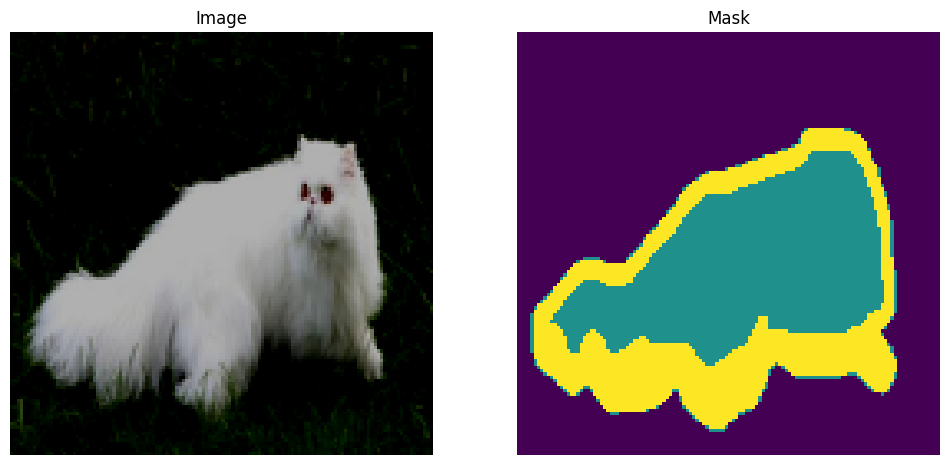

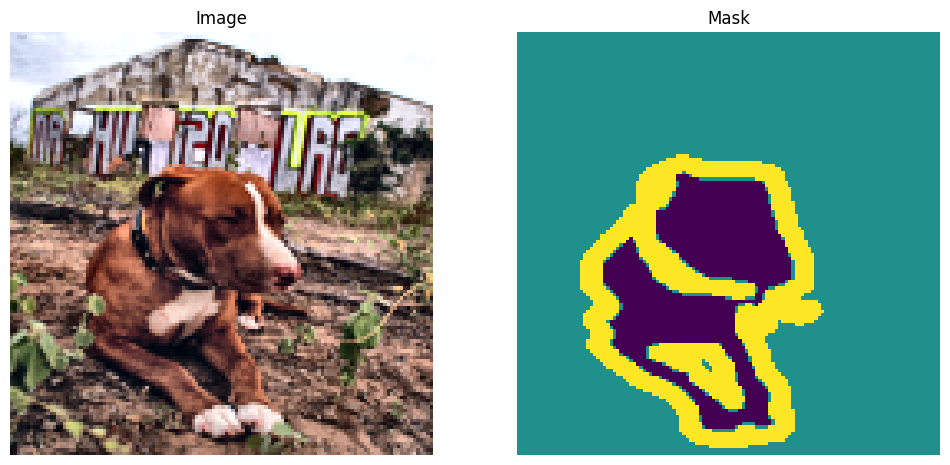

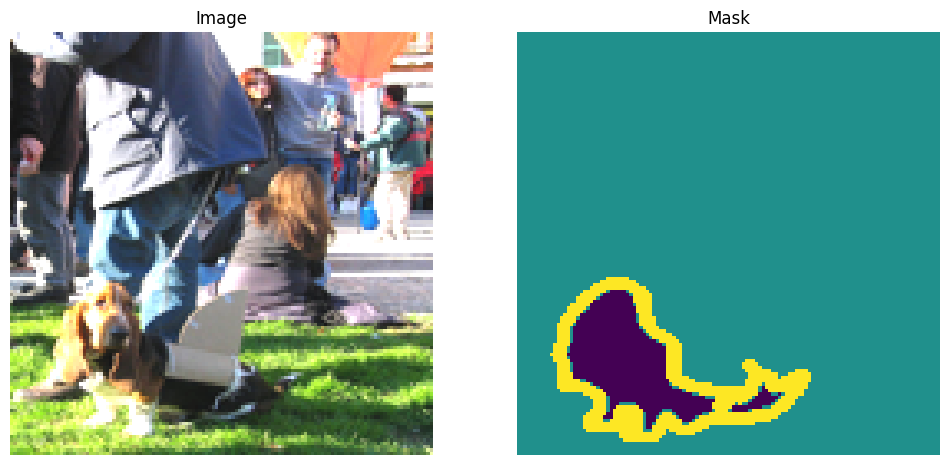

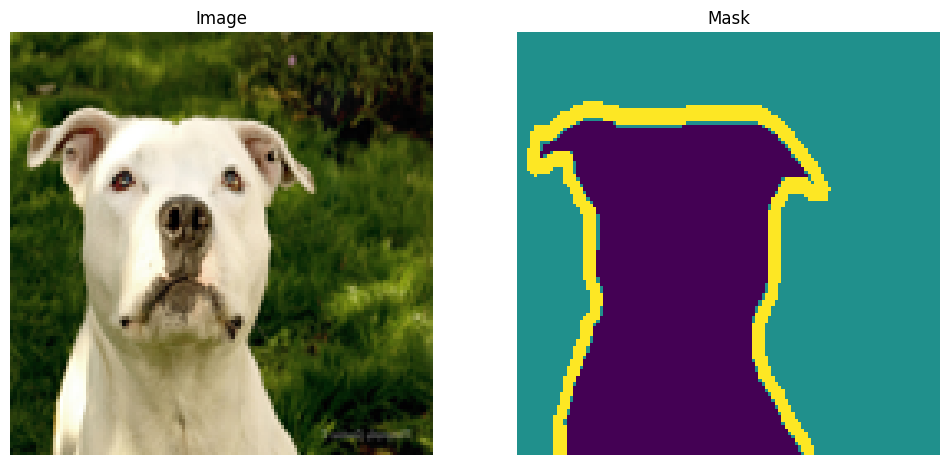

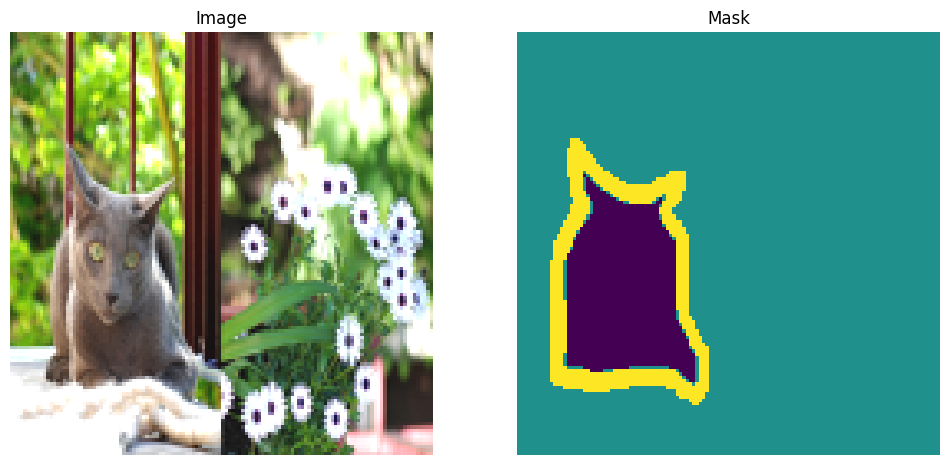

In [ ]:
import matplotlib.pyplot as plt
import random
for i in [random.choice(range(len(dataset))) for _ in range(5)]:
    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize as needed
    a=dataset[i]
    # Plot the image on the first subplot
    ax[0].imshow(a[0].permute(1,2,0).numpy())
    ax[0].axis('off')  # Hide axes for the image
    ax[0].set_title("Image")  # Title for the image

    # Plot the mask on the second subplot
    ax[1].imshow(a[1].numpy())
    ax[1].axis('off')  # Hide axes for the mask
    ax[1].set_title("Mask")  # Title for the mask

    # Show the figure
    plt.show()

In [ ]:
from torch.utils.data import DataLoader, random_split

# Calculate the split sizes
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset into training and testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for training and testing
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
class ConvolutionOperation(nn.Module):
    def __init__(self, in_channels, filters=64):
        super(ConvolutionOperation, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, filters, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(filters)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(filters, filters, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(filters)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class Encoder(nn.Module):
    def __init__(self, in_channels, filters=64):
        super(Encoder, self).__init__()
        self.conv_block = ConvolutionOperation(in_channels, filters)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        enc1 = self.conv_block(x)
        maxpool1 = self.pool(enc1)
        return enc1, maxpool1

class Decoder(nn.Module):
    def __init__(self, in_channels, skip_channels, filters=64):
        super(Decoder, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, filters, kernel_size=2, stride=2)
        self.conv_block = ConvolutionOperation(filters + skip_channels, filters)

    def forward(self, x, skip):
        x = self.upconv(x)
        x = torch.cat([x, skip], dim=1)
        x = self.conv_block(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.enc1 = Encoder(in_channels, 64)
        self.enc2 = Encoder(64, 128)
        self.enc3 = Encoder(128, 256)
        self.enc4 = Encoder(256, 512)

        self.bottleneck = ConvolutionOperation(512, 1024)

        self.dec1 = Decoder(1024, 512, 512)
        self.dec2 = Decoder(512, 256, 256)
        self.dec3 = Decoder(256, 128, 128)
        self.dec4 = Decoder(128, 64, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        skip1, x = self.enc1(x)
        skip2, x = self.enc2(x)
        skip3, x = self.enc3(x)
        skip4, x = self.enc4(x)

        x = self.bottleneck(x)

        x = self.dec1(x, skip4)
        x = self.dec2(x, skip3)
        x = self.dec3(x, skip2)
        x = self.dec4(x, skip1)

        x = self.final_conv(x)
        return x

In [ ]:
# Define model
in_channels = 3   # Example: RGB image
out_channels = 1  # Example: single-channel segmentation mask
model = UNet(in_channels, out_channels)

# Generate a random tensor (batch size=1, 3 color channels, 128x128 image)
input_tensor = torch.randn(1, in_channels, 128, 128)

# Forward pass through the model
output = model(input_tensor)

# Print output shape
print("Output shape:", output.shape)  # Expected: (1, 1, 128, 128)

Output shape: torch.Size([1, 1, 128, 128])


In [ ]:
!pip install torchinfo


In [ ]:
from torchinfo import summary

# Define model
in_channels = 3   # Example: RGB image
out_channels = 1  # Example: single-channel segmentation mask
model = UNet(in_channels, out_channels)

# Print model summary
summary(model, input_size=(1, in_channels, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 1, 128, 128]          --
├─Encoder: 1-1                           [1, 64, 128, 128]         --
│    └─ConvolutionOperation: 2-1         [1, 64, 128, 128]         --
│    │    └─Conv2d: 3-1                  [1, 64, 128, 128]         1,792
│    │    └─BatchNorm2d: 3-2             [1, 64, 128, 128]         128
│    │    └─ReLU: 3-3                    [1, 64, 128, 128]         --
│    │    └─Conv2d: 3-4                  [1, 64, 128, 128]         36,928
│    │    └─BatchNorm2d: 3-5             [1, 64, 128, 128]         128
│    │    └─ReLU: 3-6                    [1, 64, 128, 128]         --
│    └─MaxPool2d: 2-2                    [1, 64, 64, 64]           --
├─Encoder: 1-2                           [1, 128, 64, 64]          --
│    └─ConvolutionOperation: 2-3         [1, 128, 64, 64]          --
│    │    └─Conv2d: 3-7                  [1, 128, 64, 64]          73,856
│ 

In [ ]:
import torch.optim as optim
# Define Dice Loss for multi-class segmentation

# Define the model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=3).to(device)  # Assume 3 classes

ce_loss = nn.CrossEntropyLoss()  # Sparse Categorical Cross-Entropy
         # Dice Loss
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)


# Load Data (Replace `train_gen` and `val_gen` with real DataLoaders)

from torch.utils.data import DataLoader, random_split

# Calculate the split sizes
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset into training and testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for training and testing
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)



# Model Checkpointing
best_val_loss = float("inf")
checkpoint_path = "oxford_segmentation.pth"

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, num_classes=3, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, preds, targets):
        """
        Compute the Dice loss.

        Args:
            preds (torch.Tensor): Model predictions (logits) of shape (B, C, H, W).
            targets (torch.Tensor): Ground truth labels of shape (B, H, W) with values in {0, 1, 2}.

        Returns:
            torch.Tensor: Dice loss value.
        """
        preds = torch.softmax(preds, dim=1)  # Convert logits to probabilities

        targets_one_hot = torch.nn.functional.one_hot(targets, num_classes=self.num_classes)  # (B, H, W, C)
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()  # (B, C, H, W)

        dice_loss = 0.0
        for class_idx in range(self.num_classes):
            pred_class = preds[:, class_idx, :, :]
            target_class = targets_one_hot[:, class_idx, :, :]

            intersection = torch.sum(pred_class * target_class)
            union = torch.sum(pred_class) + torch.sum(target_class)

            dice_class = (2.0 * intersection + self.smooth) / (union + self.smooth)
            dice_loss += (1 - dice_class)  # Dice loss for each class

        return dice_loss / self.num_classes  # Average over all classes

diceLoss=DiceLoss()

In [ ]:
optimizer = optim.RMSprop(model.parameters(), lr=0.9e-4)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0

    for images, masks in train_dataloader:
        images, masks = images.to(device), masks.to(device, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(images)  # Output shape: (batch, num_classes, H, W)

        loss_ce = ce_loss(outputs,masks)  # CE Loss
        loss_dice = diceLoss(outputs, masks)  # Dice Loss
        total_loss = loss_ce +loss_dice  # Weighted sum of both

        total_loss.backward()
        optimizer.step()

        train_loss += total_loss.item()

    # Validation Step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_dataloader:
            images, masks = images.to(device), masks.to(device, dtype=torch.long)
            outputs = model(images)

            loss_ce = ce_loss(outputs, masks)
            loss_dice = diceLoss(outputs, masks)
            total_loss = loss_ce +loss_dice

            val_loss += total_loss.item()

    avg_train_loss = train_loss / len(train_dataloader)
    avg_val_loss = val_loss / len(val_dataloader)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Model saved at epoch {epoch+1} with val loss: {best_val_loss:.4f}")

Epoch 1/20, Train Loss: 0.3118, Val Loss: 0.4294
Epoch 2/20, Train Loss: 0.2991, Val Loss: 0.4173
Epoch 3/20, Train Loss: 0.2937, Val Loss: 0.4105
Epoch 4/20, Train Loss: 0.2902, Val Loss: 0.4266


KeyboardInterrupt: 

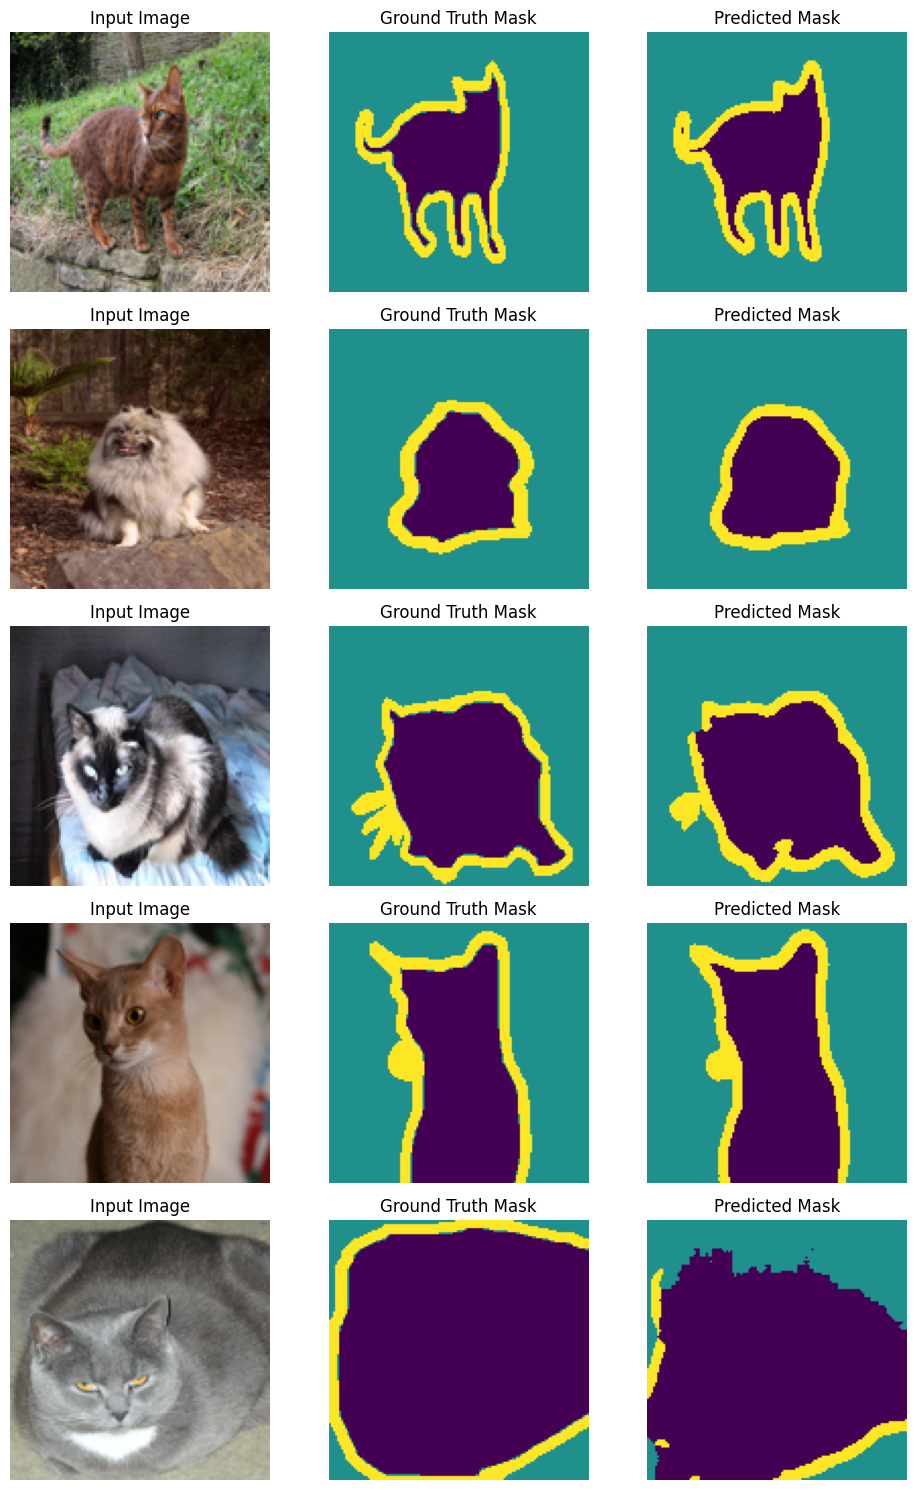

In [ ]:
import torch
import random
import matplotlib.pyplot as plt

def visualize_predictions(model, test_dataset, device, num_samples=5):
    """
    Visualize model predictions vs. ground truth masks.

    Args:
        model: The trained segmentation model.
        test_dataset: The dataset to sample from.
        device: The device to run the model on ("cuda" or "cpu").
        num_samples: Number of images to visualize (default: 5).
    """
    model.eval()
    indices = random.sample(range(len(test_dataset)), num_samples)
    fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))

    for i, idx in enumerate(indices):
        image, mask = test_dataset[idx]
        image = image.to(device).unsqueeze(0)  # Add batch dimension
        mask = mask.to(device, dtype=torch.long)

        with torch.no_grad():
            output = model(image)  # Output shape: (1, class, H, W)
            pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu()  # Convert logits to class indices

        image = image.squeeze(0).cpu().permute(1, 2, 0)  # Convert to (H, W, C) format
        mask = mask.cpu()

        axes[i, 0].imshow(image, cmap='gray')  # Adjust cmap if needed
        axes[i, 0].set_title("Input Image")

        axes[i, 1].imshow(mask, cmap='viridis')
        axes[i, 1].set_title("Ground Truth Mask")

        axes[i, 2].imshow(pred_mask, cmap='viridis')
        axes[i, 2].set_title("Predicted Mask")

        for ax in axes[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage:
visualize_predictions(model, test_dataset, device)

